In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jangedoo/utkface-new

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
import os
! unzip utkface-new

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [5]:
import os
import shutil
import random
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import keras
from os import listdir
from os.path import isdir
from PIL import Image, ImageEnhance
from numpy import asarray
from matplotlib import pyplot
import tensorflow as tf
from numpy import savez_compressed
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from keras.layers import Input
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, ReLU, BatchNormalization, Conv2D,  MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
import os
import random
import shutil
from PIL import Image, ImageEnhance

utkface_path = '/content/UTKFace/'
trial_path = '/content/Trial/'

if not os.path.exists(trial_path):
    os.mkdir(trial_path)

genders = [0, 1]
max_num_files = 30

for age in range(1, 81):
    for gender in genders:
        age_gender_files = [f for f in os.listdir(utkface_path) if f.startswith(f"{age}_{gender}_")]
        num_files = len(age_gender_files)
        if num_files < max_num_files:
            num_to_augment = max_num_files - num_files
            for i in range(num_to_augment):
                valid_files = [f for f in age_gender_files if f.split('_')[2].isdigit() and int(f.split('_')[2]) == 0]
                source_file = random.choice(valid_files)
                source_path = os.path.join(utkface_path, source_file)
                dest_file = f"{age}_{gender}_{source_file.split('_')[2]}_{num_files+i}.jpg"
                dest_path = os.path.join(trial_path, dest_file)

                # Apply image augmentation
                img = Image.open(source_path)
                enhancer = ImageEnhance.Brightness(img)
                img = enhancer.enhance(0.5)
                enhancer = ImageEnhance.Contrast(img)
                img = enhancer.enhance(0.5)
                img.save(dest_path)

        elif num_files >= max_num_files:
            num_files = max_num_files

        for i in range(num_files):
            source_file = age_gender_files[i]
            source_path = os.path.join(utkface_path, source_file)
            dest_path = os.path.join(trial_path, source_file)
            shutil.copy(source_path, dest_path)


In [17]:
num_files

30

In [18]:
len(os.listdir(trial_path))

5002

In [19]:
# Load the Haar cascade file for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
#face_cascade

files = os.listdir(trial_path)
size = len(files)
size_genders = len(genders)
print("Total samples:",size)

Total samples: 5002


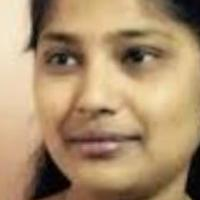

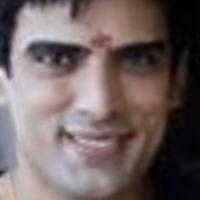

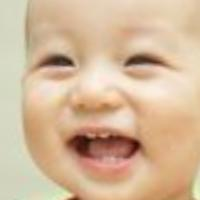

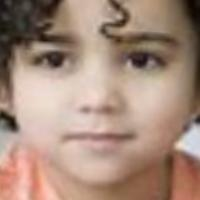

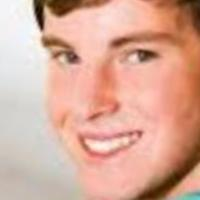

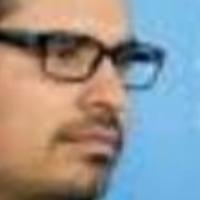

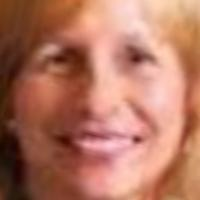

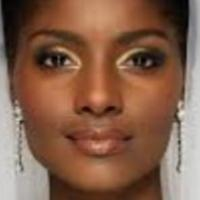

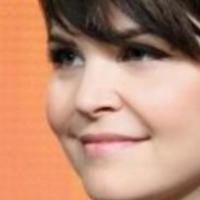

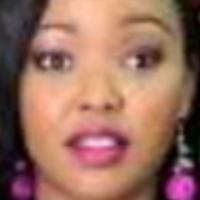

In [19]:
for i in range(10):
    image_path = os.path.join(trial_path, files[i])
    image = cv2.imread(image_path)
    cv2_imshow(image)

In [20]:
img_age_list = []
img_gender_list = []
ages = []
genders = []
ethi_all = []
filenames = []

for filename in files:
    image_age = cv2.imread(trial_path + filename, 1)
    image_age = cv2.resize(image_age, dsize=(224, 224))
    image_gender = cv2.imread(trial_path + filename, 1)
    image_gender = cv2.resize(image_gender, dsize=(224, 224))

    age = filename.split('_')[0]
    gender = filename.split('_')[1]
    ethi = filename.split('_')[2]

    # Check if 'ethi' can be converted to an integer and is equal to 0
    if ethi.isdigit() and int(ethi) == 0:
        img_age_list.append(image_age)
        img_gender_list.append(image_gender)
        ages.append(age)
        genders.append(int(gender))
        ethi_all.append(int(ethi))
        filenames.append(filename)
    else:
        continue


In [21]:
total_image_age_list = len(img_age_list)
total_image_gender_list = len(img_gender_list)
total_genders = len(genders)
total_ages = len(ages)
total_ethi = len(ethi_all)
idx = 2
print("Total samples for age:",total_image_age_list)
print("Total samples for gender:",total_ages)
print("Total samples for ethinicity:",total_ethi)

Total samples for age: 2868
Total samples for gender: 2868
Total samples for ethinicity: 2868


In [23]:
from PIL import Image, ImageEnhance

max_num_files = 25

for age in range(1, 81):
    for gender in [0, 1]:
        age_gender_files = [filename for filename in filenames if filename.startswith(f"{age}_{gender}_")]
        num_files = len(age_gender_files)
        
        if num_files < max_num_files:
            num_to_augment = max_num_files - num_files
            for _ in range(num_to_augment):
                # Randomly select an existing image
                source_idx = random.randint(0, num_files - 1)
                source_file = age_gender_files[source_idx]
                source_path = os.path.join(trial_path, source_file)
                dest_file = f"{age}_{gender}_0_{total_ethi}.jpg"
                dest_path = os.path.join(trial_path, dest_file)

                # Apply image augmentation
                img = Image.open(source_path)
                enhancer = ImageEnhance.Brightness(img)
                img = enhancer.enhance(0.5)
                enhancer = ImageEnhance.Contrast(img)
                img = enhancer.enhance(0.5)
                img.save(dest_path)

                # Update the lists with augmented image data
                img_age_list.append(img)
                img_gender_list.append(img)
                ages.append(age)
                genders.append(gender)
                ethi_all.append(0)
                filenames.append(dest_file)

        elif num_files >= max_num_files:
            num_files = max_num_files


In [30]:
total_image_age_list = len(img_age_list)
total_image_gender_list = len(img_gender_list)
total_genders = len(genders)
total_ages = len(ages)
total_ethi = len(ethi_all)
idx = 2
print("Total samples for age:",total_image_age_list)
print("Total samples for gender:",total_ages)
print("Total samples for ethinicity:",total_ethi)

Total samples for age: 7869
Total samples for gender: 7869
Total samples for ethinicity: 7869


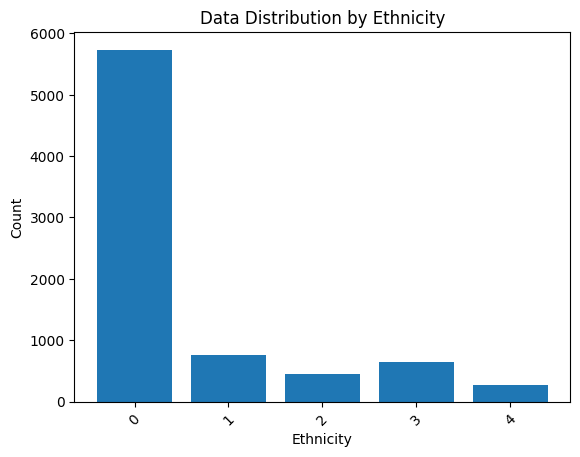

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Count the occurrences of each value in ethi_all
ethi_all_counts = np.unique(ethi_all, return_counts=True)

# Separate the values and counts
ethi_all_values = ethi_all_counts[0]
ethi_all_count_values = ethi_all_counts[1]

# Plotting the data distribution
plt.bar(ethi_all_values, ethi_all_count_values)
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Data Distribution by Ethnicity')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

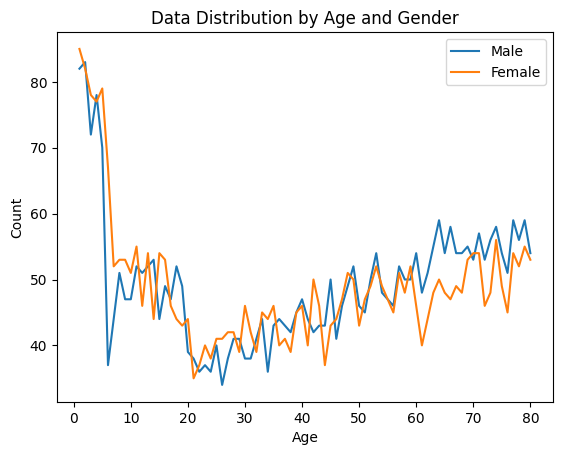

In [32]:
age_gender_counts = {}

for age in range(1, 81):
    for gender in [0, 1]:  # Assuming genders are encoded as 0 and 1
        age_gender_files = [f for f, g in zip(filenames, genders) if int(f.split('_')[0]) == age and g == gender]
        count = len(age_gender_files)
        age_gender_counts[(age, gender)] = count
        
# Separate the counts by gender
male_counts = [age_gender_counts[(age, 1)] for age in range(1, 81)]
female_counts = [age_gender_counts[(age, 0)] for age in range(1, 81)]

# Plotting the data distribution
ages1 = range(1, 81)

plt.plot(ages1, male_counts, label='Male')
plt.plot(ages1, female_counts, label='Female')

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Data Distribution by Age and Gender')
plt.legend()
plt.show()


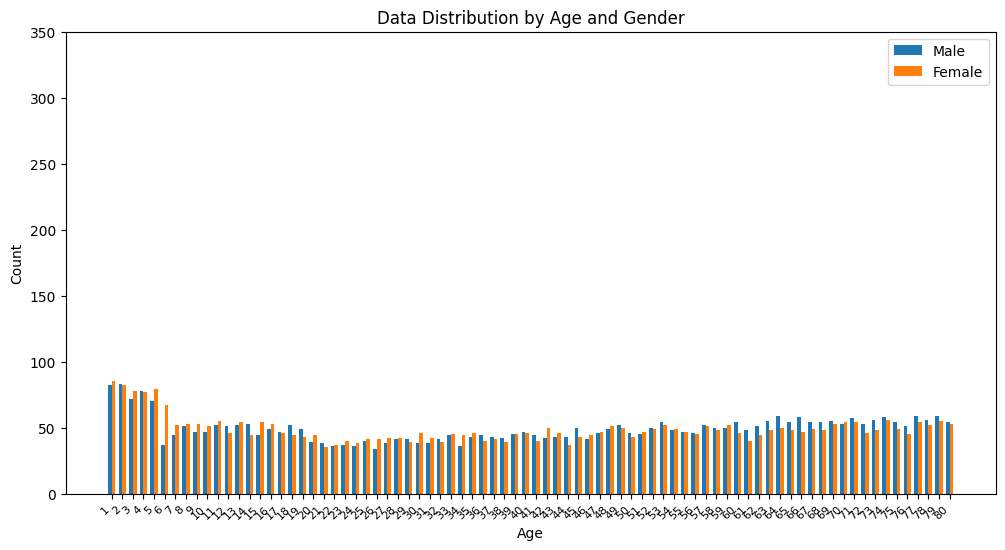

In [34]:
import matplotlib.pyplot as plt
import numpy as np

max_count = max(max(male_counts), max(female_counts))

bar_width = 0.35

bar_positions = np.arange(len(ages1))

plt.figure(figsize=(12, 6))

plt.bar(bar_positions - bar_width/2, male_counts, width=bar_width, label='Male')
plt.bar(bar_positions + bar_width/2, female_counts, width=bar_width, label='Female')

plt.xticks(bar_positions, ages1, rotation=45, ha='right', fontsize=8)
plt.ylim([0, 350])

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Data Distribution by Age and Gender')
plt.legend()

plt.show()


In [ ]:
x_genders = list(set(genders))
y_genders = [genders.count(i) for i in x_genders]

gender_labels = ['0', '1']
plt.bar(gender_labels, y_genders)

plt.show()
print("Max value:",max(genders))


In [ ]:
distribution_list = list(set(ages))
distribution_list_int = [int(s) for s in distribution_list]
distribution_list_sorted = sorted(distribution_list_int)


ages_sorted = [str(i).zfill(1) for i in distribution_list_sorted]

x_ages = list(set(ages_sorted))
x_ages = sorted(x_ages)
y_ages = [ages.count(i) for i in x_ages]

plt.figure(figsize=(15, 10)) # set the size of the figure
plt.bar(ages_sorted, y_ages)

plt.xticks(rotation=90) # rotate the x-axis labels by 90 degrees
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')

plt.show()

max_age = max(map(int, x_ages))
print("Maximum age:", max_age)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Count the occurrences of each value in ethi_all
ethi_all_counts = np.unique(ethi_all, return_counts=True)

# Separate the values and counts
ethi_all_values = ethi_all_counts[0]
ethi_all_count_values = ethi_all_counts[1]

# Plotting the data distribution
plt.bar(ethi_all_values, ethi_all_count_values)
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Data Distribution by Ethnicity')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()


In [ ]:
ethi_all

In [ ]:
labels_age = np.zeros((total_ages,1),dtype='float32')
labels_gender = np.zeros((total_genders,1),dtype='float32')
features_age = np.zeros((total_image_age_list,for_np0.shape[0],for_np0.shape[1],3),dtype = 'float32')
#features_gender = np.zeros((total_genders,sample.shape[0],sample.shape[1],3),dtype = 'float32')
features_gender = np.zeros((total_image_gender_list,for_np0.shape[0],for_np0.shape[1],3),dtype = 'float32')

In [ ]:
total_image_age_list

In [ ]:
print(labels_age.shape)
print(features_age.shape)
print(labels_gender.shape)
print(features_gender.shape)

In [ ]:
for i in range(total_image_age_list):
    labels_gender[i, 0] = int(genders[i])
    labels_age[i, 0] = int(ages[i])
    features_age[i] = img_age_list[i]
    features_gender[i] = img_gender_list[i]

In [ ]:
labels_age[555]

In [ ]:
labels_gender[4]

In [ ]:
cv2_imshow(features_age[0])

In [ ]:
cv2_imshow(features_gender[0])

In [ ]:
# Rescale pixel values to range [0,255]
features_first_img = np.clip(features_age[0], 0, 255)

cv2_imshow(features_first_img)
print("First image in features")


In [ ]:
normalized_age = features_age / 255 #normalization
normalized_gender = features_gender /255
features_age[0]

In [ ]:
features_first_img_after_normalization = np.clip(features_age[0], 0, 255)
plt.imshow(features_first_img_after_normalization[:, :], vmin=0, vmax=1)
#plt.imshow(features_first_img_after_normalization[:, :, ::-1], vmin=0, vmax=1)
plt.axis('off')

plt.title("First Image in Features after normalization")

plt.show()


In [ ]:
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(normalized_age, labels_age, test_size=0.2,shuffle  = True)

In [ ]:

print("--------------------------------------")
print('number of x_train for age: ', len(x_train_age))
print('number of x_test for age: ', len(x_test_age))
print('number of y_train for age: ', len(y_train_age))
print('number of y_test for age:', len(y_test_age))

print("--------------------------------------")
print('x_train type for age:', type(x_train_age))
print('x_test type for age:', type(x_test_age))
print('y_train type for age:', type(y_train_age))
print('y_test type for age:', type(y_test_age))
print("--------------------------------------")

print(y_train_age.shape)

print(y_test_age.shape)


In [ ]:
for i in range(10):
  filenumber = img_gender_list[i]
  cv2_imshow(filenumber)
  name_of_files = filenames[i]
  print("Filename:", name_of_files)
  print("Actual age:", ages[i])
  print("Gender:", genders[i])

In [ ]:
from keras.initializers import GlorotNormal

#age
input_shape = (224, 224, 3)
inputs_age = Input(shape=input_shape)

x_age = Conv2D(32, (3,3), activation='relu', kernel_initializer=GlorotNormal())(inputs_age)
x_age = MaxPooling2D((2, 2))(x_age)
x_age = Dropout(0.5)(x_age)
x_age = Conv2D(64, (3,3), activation='relu', kernel_initializer=GlorotNormal())(x_age)
x_age = MaxPooling2D((2, 2))(x_age)
x_age = Dropout(0.5)(x_age)
x_age = Conv2D(128, (3,3), activation='relu', kernel_initializer=GlorotNormal())(x_age)
x_age = MaxPooling2D((2, 2))(x_age)
x_age = Dropout(0.5)(x_age)

x_age = Flatten()(x_age)
x_age = Dense(64, activation='relu', kernel_initializer=GlorotNormal())(x_age)
outputs_age = Dense(1, activation='linear', kernel_initializer=GlorotNormal())(x_age)

neural_network_age = Model(inputs=inputs_age, outputs=outputs_age)
neural_network_age.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [ ]:
# Define some callbacks to avoid overfitting
callbacks = [ ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=2) ]

# Train the model
history_age = neural_network_age.fit(x_train_age, y_train_age,
                    batch_size = 20,
                    epochs=45,
                    validation_data=(x_test_age, y_test_age),
                    callbacks=callbacks)


In [ ]:
age_pred = neural_network_age.predict(x_test_age)


In [ ]:
for i in range(50):
  filenumber = img_gender_list[i]
  cv2_imshow(filenumber)
  name_of_files = filenames[i]
  print("Filename:", name_of_files)
  print("Real age    | Predict age")
  print(ages[i], "         |" , int(age_pred[i]))

In [ ]:
plt.plot(history_age.history['mae'])
plt.plot(history_age.history['val_mae'])
plt.title('CNN model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(["MAE","Validation MAE"])
plt.show()

In [ ]:
plt.plot(history_age.history['loss'])
plt.plot(history_age.history['val_loss'])
plt.title('CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["loss","Validation Loss"])
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_age, age_pred))
print("RMSE of age model: ", rmse)

In [ ]:
def error_count(error):
  error1 = 0
  error2 = 0
  error3 = 0
  error4 = 0
  if error < 5:
    error1 = error1+1
  elif error <= 10:
    error2 = error2+1
  elif error <= 15:
    error3 = error3+1
  elif error > 15:
    error4 = error4+1
  return error1,error2,error3,error4

In [ ]:
predicted_age_list = []
y_test_list = []
error1_total = 0
error2_total = 0
error3_total = 0
error4_total = 0

for i in range(len(x_test_age)):
    #image = x_test_gender[i]
    #name_of_files = x_test_age[i]
    predicted_age = neural_network_age.predict(np.expand_dims(x_test_age[i], axis=0))
    predicted_age = int(predicted_age)
    predicted_age_list.append(predicted_age)
    percent_dif =  (abs(predicted_age-int(y_test_age[i]))/ int(max_age)) * 100
    error_count(percent_dif)
    error1, error2, error3, error4 = error_count(percent_dif)
    error1_total += error1
    error2_total += error2
    error3_total += error3
    error4_total += error4

print("Number of error less than 5%:", error1_total)
print("Number of error less than 10%:", error2_total)
print("Number of error equal or less than 15%:", error3_total)
print("Number of error more than 15%:", error4_total)

In [ ]:
percentage_error1 = (error1_total/len(x_test_age))*100
percentage_error2 = (error2_total/len(x_test_age))*100
percentage_error3 = (error3_total/len(x_test_age))*100
percentage_error4 = (error4_total/len(x_test_age))*100
print("Percentage of file that have 0-5 % error : ", round(percentage_error1,2), " %")
print("Percentage of file that have 6-10 % error: ", round(percentage_error2,2), " %")
print("Percentage of file that have 11-15 % error:", round(percentage_error3,2), " %")
print("Percentage of file that have more than 15% error : ", round(percentage_error4,2), " %")

In [ ]:

values = [error1_total, error2_total, error3_total, error4_total]
labels = ['<5%', '<10%', '<=15%', '>15%']

# Plot the bar graph
plt.bar(labels, values)

# Add labels to the graph
plt.title('%error Glorot normal')
plt.xlabel('Percentage error')
plt.ylabel('Count')

# Display the graph
plt.show()
